# Titanic

## Integrantes:
- Nicolas Nuñez
- Agustin Davila
- Leandro Sgroi
- Nicolas Lambertucci

## Preprocecamiento

In [178]:
# Importar librerias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [182]:
# Importar los datos

data_train = pd.read_csv("./train.csv") 
x_test_kaggle = pd.read_csv("./test.csv")

x = data_train.drop(["Survived", "PassengerId"], axis=1)
y = data_train.Survived

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=25)

print(f"Tipo de datos:\n{x_train.dtypes}\n")
print(f"Cantidad de filas de los datos de entrenamiento {x_train.shape[0]}\n")
print(f"Cantidad de columnas de los datos de entrenamiento {x_train.shape[1]}\n")
x_train.head()

Tipo de datos:
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Cantidad de filas de los datos de entrenamiento 623

Cantidad de columnas de los datos de entrenamiento 10



,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
707,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
246,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25.0,0,0,347071,7.7750,NaN,S
624,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,54636,16.1000,NaN,S
96,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
576,2,"Garside, Miss. Ethel",female,34.0,0,0,243880,13.0000,NaN,S


In [184]:
# Seleccion de columnas

numeric_columns = [
   column for column in x_train.columns
   if x_train[column].dtype == "float64" or x_train[column].dtype == "int64"
]

categoric_columns = [
   column for column in x_train.columns
   if x_train[column].nunique() < 10 and x_train[column].dtype == "object"
]

print(f"Columnas numericas {numeric_columns}")
print(f"Columnas categoricas {categoric_columns}")

selected_columns = numeric_columns + categoric_columns

prep_data_train = x_train[selected_columns].copy()
prep_data_test_kaggle = x_test_kaggle[selected_columns].copy()
prep_data_test = x_test[selected_columns].copy()

Columnas numericas ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Columnas categoricas ['Sex', 'Embarked']


In [185]:
# Preprocesamineto para datos numéricos
from sklearn.preprocessing import OneHotEncoder
numerical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='constant')),
   ('scalar', StandardScaler()),
])

# Preprocesamiento para datos categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Agrupa el procesamiento para datos numéricos y categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categoric_columns)
    ])

## Seleccion de modelo

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Instanciacion de modelo

In [248]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

pipeline = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('model', model),
                        ]
                   )

print(model.get_params())
hyperparameters = { 'model__max_depth' : [2, 6, 10],
                    'model__min_samples_split': [2, 8, 16],
                    'model__n_estimators': [100, 300, 600, 900]
                  }

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


### Optimizacion de modelo

In [249]:
clf = GridSearchCV(pipeline, hyperparameters, cv = 10)

### Entrenamiento y prediccion

In [250]:
# Entrenamiento
clf.fit(prep_data_train, y_train)
# print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

0.8218894009216589
{'model__max_depth': 10, 'model__min_samples_split': 8, 'model__n_estimators': 900}


In [252]:

# Obtencion de predicciones
test_result = clf.predict(prep_data_test)
kaggle_result = clf.predict(prep_data_test_kaggle)

## Evaluacion de modelos

In [195]:
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
import seaborn as sns

### Evaluacion global

In [253]:
clf.score(prep_data_test, y_test)

0.8208955223880597

### Evaluacion cruzada con MAE

In [254]:
scores = -1 * cross_val_score(pipeline, prep_data_train, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [0.216      0.176      0.168      0.16129032 0.23387097]
Average MAE score (across experiments):
0.19103225806451613


### Evaluacion cruzada estratificada

In [246]:
skfold = StratifiedKFold(n_splits=10)
scores= model_selection.cross_val_score(pipeline, prep_data_train, y_train, cv=skfold, scoring='f1_macro')

print("F1: %.2f%%" % (scores.mean()*100.0))

print('F1: {}'.format(scores))

print('F1: {0: .3f} +/- {1: .3f}'.format(np.mean(scores),
                                          np.std(scores)))

F1: 78.99%
F1: [0.62930793 0.88470588 0.83173077 0.78863636 0.86594595 0.76315016
 0.79605263 0.85909091 0.7620614  0.71818182]
F1:  0.790 +/-  0.073


### Evaluacion por matriz de confusion

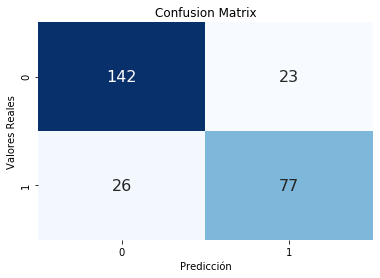

In [247]:
labels = [0, 1]
cm = confusion_matrix(y_test, test_result)
ax= plt.subplot()
sns.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, cbar=False, fmt='g'); 
ax.set_xlabel('Predicción');ax.set_ylabel('Valores Reales'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [194]:
print(classification_report(y_test, test_result))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       165
           1       0.75      0.74      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268



## Exportar prediccion

In [157]:
result_df = pd.DataFrame(kaggle_result)
result_df.index = data_test.PassengerId
result_df.rename(columns={0: "Survived"}, inplace=True)
print(result_df)
result_df.to_csv("team_result.csv")

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 1
896                 1
...               ...
1305                0
1306                1
1307                0
1308                0
1309                1

[418 rows x 1 columns]
